# Final trigger SFs plots, after OR of triggers
Calls the actual trigSF producer with cppyyy
You can edit Htt_trigSFinterface.h and change "private" to "public" which allows for testing individual scale factors

In [1]:
from Tools.Tools.Htt_trigSF import Htt_trigSFRDFProducer
import ROOT
import JupyROOT.helpers.utils
JupyROOT.helpers.utils.GetGeometryDrawer = lambda:None # magic fix to make ROOT faster
import cppyy
import numpy as np
import hist
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import math

Welcome to JupyROOT 6.24/07


In [2]:
sf_producer = Htt_trigSFRDFProducer(year=2018, isMC=True, isUL=True, ispreVFP=False)

In [3]:
def get_sf(pairType, dau1_decayMode, dau1_pt, dau1_eta, dau2_decayMode, dau2_pt, dau2_eta):
    #                                                     isVBFtrigger
    return list(cppyy.gbl.Htt_trigSF.get_scale_factors(pairType, False,
                            dau1_decayMode, dau1_pt, dau1_eta,
                            dau2_decayMode, dau2_pt, dau2_eta,
                            -999, -999, -999, -999,
                            -999, -999, -999, -999))

In [37]:
print(cppyy.gbl.Htt_trigSF.muTrgSF.get_EfficiencyData(20, 2), cppyy.gbl.Htt_trigSF.muTrgSF.get_EfficiencyMC(20, 2))
print(cppyy.gbl.Htt_trigSF.muTauTrgSF.get_EfficiencyData(20, 2), cppyy.gbl.Htt_trigSF.muTauTrgSF.get_EfficiencyMC(20, 2))
print(cppyy.gbl.Htt_trigSF.tauTrgSF_mutau.getEfficiencyData(20, 1), cppyy.gbl.Htt_trigSF.tauTrgSF_mutau.getEfficiencyMC(20, 1))

1.0 1.0
0.17269781231880188 0.17587313055992126
0.019730184227228165 0.03181680664420128


In [39]:
cppyy.gbl.Htt_trigSF.mutau_pt_th2_

32.0

In [8]:
get_sf(pairType=0, dau1_decayMode=0, dau1_eta=2, dau2_decayMode=1,  dau2_eta=1,   dau1_pt=20, dau2_pt=25)

[nan,
 1.0,
 0.8745761459432161,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

WARNING in ScaleFactor::get_EfficiencyData(double pt, double eta) from LepEffInterface/src/ScaleFactor.cc: pT too low (pt = 20), min value is 26. Returned efficiency =1. Weight will be 1. 
WARNING in ScaleFactor::get_EfficiencyData(double pt, double eta) from LepEffInterface/src/ScaleFactor.cc: pT too low (pt = 20), min value is 26. Returned efficiency =1. Weight will be 1. 
WARNING in ScaleFactor::get_EfficiencyData(double pt, double eta) from LepEffInterface/src/ScaleFactor.cc: pT too low (pt = 20), min value is 26. Returned efficiency =1. Weight will be 1. 
WARNING in ScaleFactor::get_EfficiencyData(double pt, double eta) from LepEffInterface/src/ScaleFactor.cc: pT too low (pt = 20), min value is 26. Returned efficiency =1. Weight will be 1. 
WARNING in ScaleFactor::get_EfficiencyData(double pt, double eta) from LepEffInterface/src/ScaleFactor.cc: pT too low (pt = 20), min value is 26. Returned efficiency =1. Weight will be 1. 
WARNING in ScaleFactor::get_EfficiencyData(double pt, d

In [15]:
def sumErrors(sf_l, pairType):
    if pairType == 0:
        uncertainties_idx = [3, 4] + list(range(7, 14+1))
    elif pairType == 1:
        uncertainties_idx = list(range(5, 14+1))
    else:
        uncertainties_idx = list(range(7, 14+1))
    sum_sq = 0.
    for idx in uncertainties_idx:
        sum_sq += (sf_l[idx] - sf_l[0])**2
    return math.sqrt(sum_sq) / 2 # symmetrize uncertainty
    

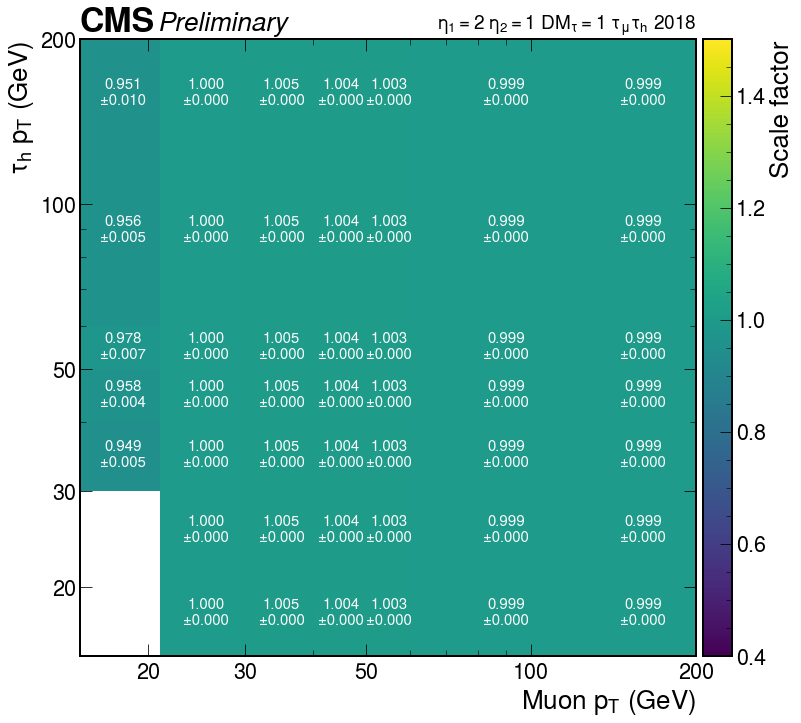

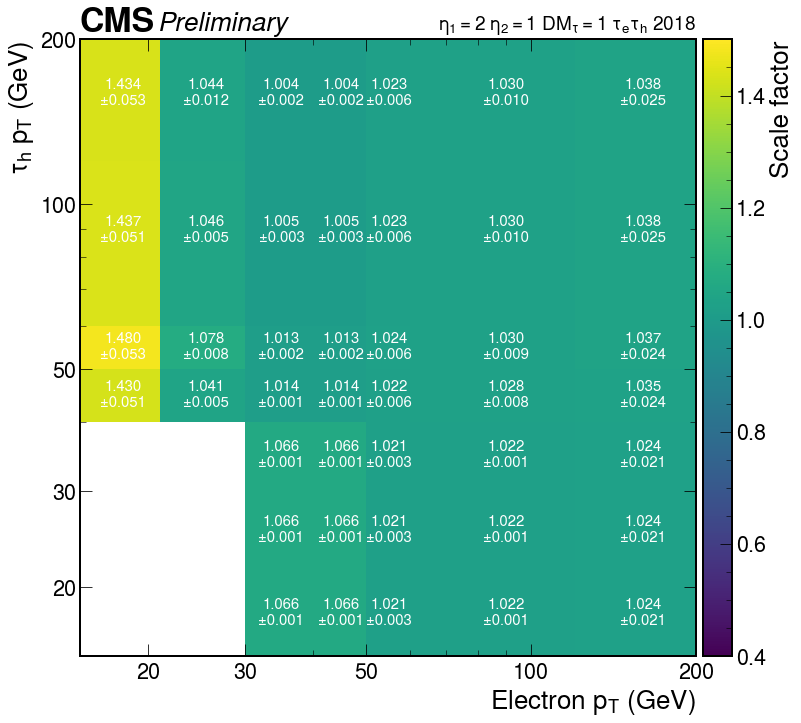

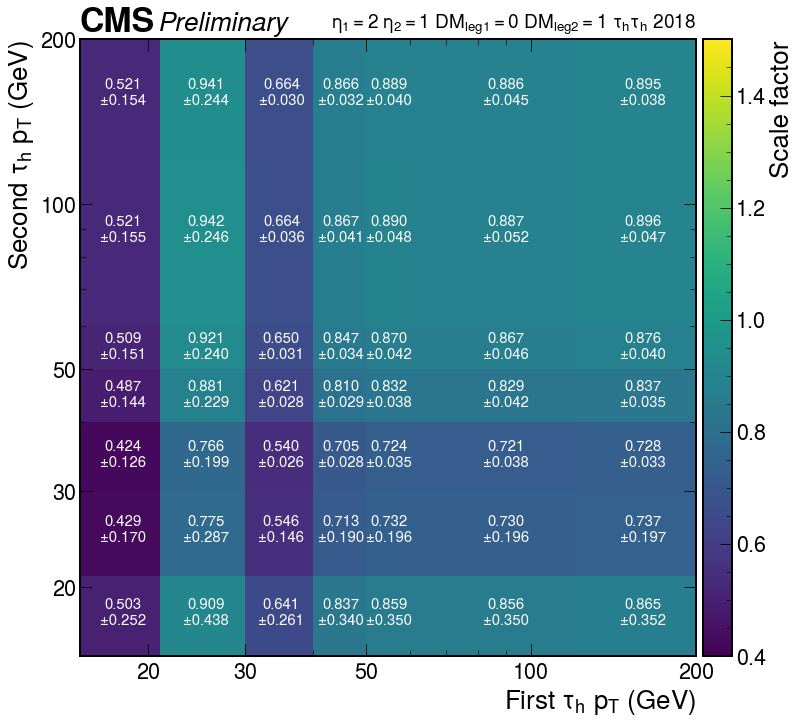

In [35]:
def makePlot(**kwargs):
    #kwargs=dict(pairType=0, dau1_decayMode=0, dau1_eta=2, dau2_decayMode=1,  dau2_eta=1)
    pairType = kwargs["pairType"]
    fig, (ax) = plt.subplots(figsize=(12, 12))
    mutau_bins = [15, 21, 30, 40, 50, 60, 120, 200]

    h = hist.Hist(hist.axis.Variable(mutau_bins, name="dau1_pt", label="dau1 pt (GeV)"), hist.axis.Variable(mutau_bins, name="dau2_pt", label="dau2 pt (GeV)"))
    mesh = np.zeros((len(h.axes[0]), len(h.axes[1])))
    uncertainties = np.zeros((len(h.axes[0]), len(h.axes[1])))
    for bin0 in range(len(h.axes[0])):
        for bin1 in range(len(h.axes[1])):
            sfs = get_sf(**kwargs, dau1_pt=h.axes[0].centers[bin0], dau2_pt=h.axes[1].centers[bin1])
            mesh[bin0, bin1] = sfs[0]
            uncertainties[bin0, bin1] = sumErrors(sfs, kwargs["pairType"])

    xbins, xtick_labels = hep.utils.get_plottable_protocol_bins(h.axes[0])
    ybins, ytick_labels = hep.utils.get_plottable_protocol_bins(h.axes[1])
    X, Y = np.meshgrid(xbins, ybins)

    pc = ax.pcolormesh(X, Y, mesh.T, vmin=0.4, vmax=1.5)

    for bin0 in range(len(h.axes[0])):
        for bin1 in range(len(h.axes[1])):
            if mesh[bin0, bin1] > 0:  # Only annotate bins with counts
                ax.text(h.axes[0].centers[bin0], 
                        h.axes[1].centers[bin1], 
                        f'{mesh[bin0, bin1]:.3f}\n±{uncertainties[bin0, bin1]:.3f}', 
                        color='white', ha='center', va='center', fontsize=15)

    if kwargs["pairType"] == 0:
        plt.xlabel(r"Muon $p_T$ (GeV)")
    elif kwargs["pairType"] == 1:
        plt.xlabel(r"Electron $p_T$ (GeV)")
    elif kwargs["pairType"] == 2:
        plt.xlabel(r"First $\tau_h$ $p_T$ (GeV)")
    if kwargs["pairType"] != 2:
        plt.ylabel(r"$\tau_h$ $p_T$ (GeV)")
    else:
        plt.ylabel(r"Second $\tau_h$ $p_T$ (GeV)")

    plt.xscale("log")
    plt.yscale("log")
    import matplotlib
    plt.gca().set_xticks([20, 30, 50, 100, 200])
    plt.gca().set_yticks([20, 30, 50, 100, 200])
    plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    cb_ax = hep.make_square_add_cbar(ax)
    plt.colorbar(pc, label="Scale factor", cax=cb_ax)

    hep.cms.text("Preliminary",ax=ax)
    if pairType == 0:
        ch_legend = r"$\tau_\mu\tau_h$"
    elif pairType == 1:
        ch_legend = r"$\tau_e\tau_h$"
    elif pairType == 2:
        ch_legend = r"$\tau_h\tau_h$"
    if pairType == 2:
        DM_text = r"$DM_{leg 1} = " f"{kwargs['dau1_decayMode']}$ " r"$DM_{leg 2} = " f"{kwargs['dau2_decayMode']}$"
    else:
        DM_text = r"$DM_{\tau} = " f"{kwargs['dau2_decayMode']}$"
    hep.cms.lumitext(f"$\\eta_1={kwargs['dau1_eta']}$ $\\eta_2={kwargs['dau2_eta']}$ {DM_text} {ch_legend} 2018", ax=ax, fontsize=20)

makePlot(pairType=0, dau1_decayMode=0, dau1_eta=2, dau2_decayMode=1,  dau2_eta=1)
plt.savefig("sf_etau.pdf", bbox_inches="tight")
makePlot(pairType=1, dau1_decayMode=0, dau1_eta=2, dau2_decayMode=1,  dau2_eta=1)
plt.savefig("sf_mutau.pdf", bbox_inches="tight")
makePlot(pairType=2, dau1_decayMode=0, dau1_eta=2, dau2_decayMode=1,  dau2_eta=1)
plt.savefig("sf_tautau.pdf", bbox_inches="tight")

In [70]:
mesh

array([[       nan,        nan, 0.94890418, 0.95767803, 0.97809097,
        0.95577728, 0.95106675],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [1.00492105, 1.00492105, 1.00492105, 1.00492105, 1.00492105,
        1.00492105, 1.00492105],
       [1.00374334, 1.00374334, 1.00374334, 1.00374334, 1.00374334,
        1.00374334, 1.00374334],
       [1.00257411, 1.00257411, 1.00257411, 1.00257411, 1.00257411,
        1.00257411, 1.00257411],
       [0.99889461, 0.99889461, 0.99889461, 0.99889461, 0.99889461,
        0.99889461, 0.99889461],
       [0.99892527, 0.99892527, 0.99892527, 0.99892527, 0.99892527,
        0.99892527, 0.99892527]])

In [12]:
for x in h.axes[0]:
    print(x)

(20.0, 21.6)
(21.6, 23.2)
(23.2, 24.799999999999997)
(24.799999999999997, 26.400000000000002)
(26.400000000000002, 28.0)
(28.0, 29.6)
(29.6, 31.200000000000003)
(31.200000000000003, 32.8)
(32.8, 34.400000000000006)
(34.400000000000006, 36.0)
(36.0, 37.6)
(37.6, 39.2)
(39.2, 40.8)
(40.8, 42.400000000000006)
(42.400000000000006, 44.0)
(44.0, 45.599999999999994)
(45.599999999999994, 47.2)
(47.2, 48.8)
(48.8, 50.4)
(50.4, 52.0)
(52.0, 53.6)
(53.6, 55.2)
(55.2, 56.8)
(56.8, 58.4)
(58.4, 60.0)
(60.0, 61.6)
(61.6, 63.2)
(63.2, 64.80000000000001)
(64.80000000000001, 66.39999999999999)
(66.39999999999999, 68.0)
(68.0, 69.6)
(69.6, 71.2)
(71.2, 72.8)
(72.8, 74.4)
(74.4, 76.0)
(76.0, 77.6)
(77.6, 79.2)
(79.2, 80.8)
(80.8, 82.4)
(82.4, 84.0)
(84.0, 85.6)
(85.6, 87.2)
(87.2, 88.8)
(88.8, 90.4)
(90.4, 92.0)
(92.0, 93.6)
(93.6, 95.2)
(95.2, 96.8)
(96.8, 98.4)
(98.4, 100.0)
